Here, we show that random configuration of $\Omega_\ell^{(0)}$ and $\Gamma_\ell$ drawn from certain families of distributions will result in stasis. From previous work, it is clear that power-law distributed rates and abundances give rise to stasis epochs. However, from following gradient flow on the full parameter space, we additionally motivated the study of log-uniformly distributed rates and abundances. We begin by defining the distributions of interest that we sample from.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from numpyro import distributions as dist
import jax.numpy as jnp
import jax
import sys

scripts = '../scripts'
sys.path.append(scripts)

from stasis_simulation_non_diff import NonDiffStasisSolver
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define a function to sample from a power law distribution
def sample_power_law(key, scale, alpha, batch_size, num_species):
    pareto = dist.Pareto(scale, alpha)
    samples = pareto.sample(key, sample_shape=(batch_size, num_species))
    inverse_samples = jnp.log10(1.0 / samples)
    return inverse_samples

## We generate samples from a uniform, and then transform them to a log-uniform distribution before entering the simulation.
def sample_uniform(low, high, batch_size, num_species):
    samples = np.random.uniform(low, high, (batch_size, num_species))
    return samples


We have power-law draws denoted $X \sim \ell^\beta$ and log-uniform draws denoted as $X \sim \text{Log-U}(10^{-\beta}, 10^0)$, where the upper bound on the log-uniform distributions is chosen when keeping in mind that decay rates are in units of planck mass, i.e. $\max(\Gamma_\ell) = 1 M_p$. You see that in order to generate power-law samples, we produce samples from a Pareto distribution, $X \sim \text{Pareto}(\alpha_p = 1/\beta)$ and then invert the samples. We want to study stasis configurations $\mathcal{N}$ and $\overline{\Omega}_M$ for parameters drawn from these families of distributions as a function of the number of species $N$ and and distribution parameter $\beta$

In [3]:
def generate_uniform_samples(N, lower_omega, lower_gamma):

    Omega_0_init = jnp.sort(sample_uniform(low=lower_omega, high = 1, batch_size = 1, num_species = N))
    Gamma_0_init = np.sort(sample_uniform(low=lower_gamma, high = 1, batch_size = 1, num_species = N))
    Gamma_0_init[:, -1] = 0.1
        
    return Omega_0_init, Gamma_0_init


def generate_power_law_samples(N, alpha, gamma):

    key = jax.random.PRNGKey(0)
    omega_samples = sample_power_law(jax.random.PRNGKey(0), 10, 1./alpha, 1, N)
    Omega_0_init = np.sort(omega_samples)
    gamma_samples = sample_power_law(jax.random.PRNGKey(0), 10, 1./gamma, 1, N)
    Gamma_0_init = np.sort(gamma_samples)

    return Omega_0_init, Gamma_0_init

In [4]:
NUM_REALIZATIONS = 5
log_uniform_jobs, power_law_jobs = [], []
N = 100
for lower_omega in [-5*k for k in range(10)]:
    for lower_gamma in [-5*k for k in range(10)]:
        for _ in range(NUM_REALIZATIONS):
            log_uniform_jobs.append([N, lower_omega, lower_gamma])      

for alpha in [2**k for k in range(-4,5)]:
    for gamma in [-1,1,2,3,3,5,6,7]:
        for _ in range(NUM_REALIZATIONS):
            power_law_jobs.append([N, alpha, gamma])

uniform_params = Parallel(n_jobs=-1)(delayed(generate_uniform_samples)(*job) for job in log_uniform_jobs)
power_law_params = Parallel(n_jobs=-1)(delayed(generate_power_law_samples)(*job) for job in power_law_jobs)

In [5]:
log_uniform_params = 10**np.array(uniform_params)
power_law_params = 10**np.array(power_law_params)

With parameter configurations in hand, it now remains to run these $\Omega_\ell^{(0)}$ and $\Gamma_\ell$ through the stasis simulation. This next cell can take a while to run, depending on your machine.

In [6]:
def run_simulation(omegas, gammas):
    sim = NonDiffStasisSolver(Omega_0=omegas[0], Gamma_0=gammas[0], H_0 = 1.)
    stasis_val, asymptote_val = sim.return_stasis()
    return stasis_val, asymptote_val

log_uniform_results = Parallel(n_jobs=-1)(delayed(run_simulation)(omegas, gammas) for omegas, gammas in tqdm(log_uniform_params));
power_law_results = Parallel(n_jobs=-1)(delayed(run_simulation)(omegas, gammas) for omegas, gammas in tqdm(power_law_params));

100%|██████████| 360/360 [01:27<00:00,  4.11it/s]


Compiling all the results into a dataframe to be viewed as a heatmap...

In [7]:
def create_data_dict(jobs, params, results, model):
    if model == 'power-law':
        data_dict = {'N':[], 'alpha': [], 'gamma': [], 'omegas':[], 'gammas':[], 'stasis_val':[], 'abundance_val':[]}

        for (N, alpha, gamma), (omegas, gammas), (jax_val, jax_asymptote) in zip(jobs, params, results):

            if jax_val == 0:
                jax_val = jnp.array(0.)
                jax_asymptote = jnp.array(0.) 

            data_dict['N'].append(N)
            data_dict['alpha'].append(alpha)
            data_dict['gamma'].append(gamma)
            data_dict['omegas'].append(omegas)
            data_dict['gammas'].append(gammas)
            data_dict['stasis_val'].append(float(jax_val))
            data_dict['abundance_val'].append(float(jax_asymptote))

            df = pd.DataFrame(data_dict)
            
    elif model == 'log-uniform':
        data_dict = {'N':[], 'lower_omega': [], 'lower_gamma': [], 'omegas':[], 'gammas':[], 'stasis_val':[], 'abundance_val':[]}

        for (N, lower_omega, lower_gamma), (omegas, gammas), (jax_val, jax_asymptote) in zip(jobs, params, results):

            if jax_val == 0:
                jax_val = jnp.array(0.)
                jax_asymptote = jnp.array(0.) 

            data_dict['N'].append(N)
            data_dict['lower_omega'].append(lower_omega)
            data_dict['lower_gamma'].append(lower_gamma)
            data_dict['omegas'].append(omegas)
            data_dict['gammas'].append(gammas)
            data_dict['stasis_val'].append(float(jax_val))
            data_dict['abundance_val'].append(float(jax_asymptote))

            df = pd.DataFrame(data_dict)
    
    return data_dict, df

power_law_data_dict, power_law_df = create_data_dict(power_law_jobs, power_law_params, power_law_results, 'power-law')
log_uniform_data_dict, log_uniform_df = create_data_dict(log_uniform_jobs, log_uniform_params, log_uniform_results, 'log-uniform')

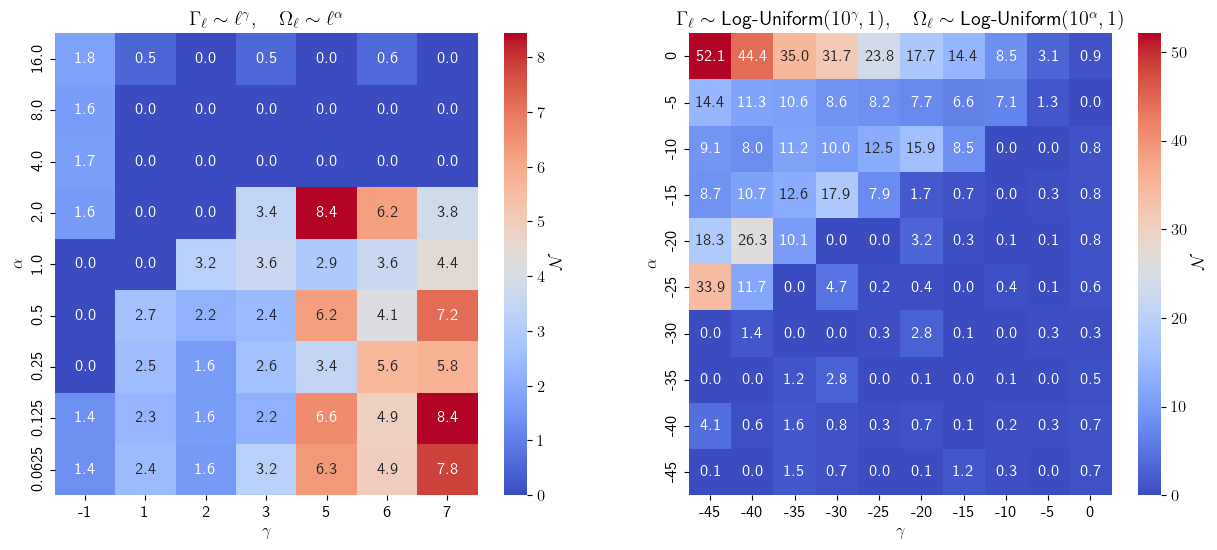

<Figure size 640x480 with 0 Axes>

In [8]:
heatmap_data_power_law = power_law_df.pivot_table(index='alpha', columns='gamma', values='stasis_val', aggfunc='mean')
heatmap_data_log_uniform = log_uniform_df.pivot_table(index='lower_omega', columns='lower_gamma', values='stasis_val', aggfunc='mean')

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'  # Add more packages if needed
plt.rcParams['font.size'] = 12

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(heatmap_data_power_law, annot=True, cmap='coolwarm', fmt=".1f", cbar_kws={'label': r'$\mathcal{N}$'}, annot_kws={"ha": 'center', "va": 'center'}, ax=axs[0])
axs[0].set_title(r'$\Gamma_\ell \sim \ell^\gamma,\quad  \Omega_\ell \sim \ell^\alpha$')
axs[0].set_xlabel(r'$\gamma$')
axs[0].set_ylabel(r'$\alpha$')
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].invert_yaxis()

sns.heatmap(heatmap_data_log_uniform, annot=True, cmap='coolwarm', fmt=".1f", cbar_kws={'label': r'$\mathcal{N}$'}, annot_kws={"ha": 'center', "va": 'center'}, ax=axs[1])
axs[1].set_title(r'$\Gamma_\ell \sim \text{Log-Uniform}(10^{\gamma}, 1),\quad  \Omega_\ell \sim \text{Log-Uniform}(10^{\alpha}, 1)$')
axs[1].set_xlabel(r'$\gamma$')
axs[1].set_ylabel(r'$\alpha$')
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].invert_yaxis()

plt.show()
plt.tight_layout()

We see that the log-uniform distributed parameters have more robust epochs of stasis. Lets also look at the stasis abundances.

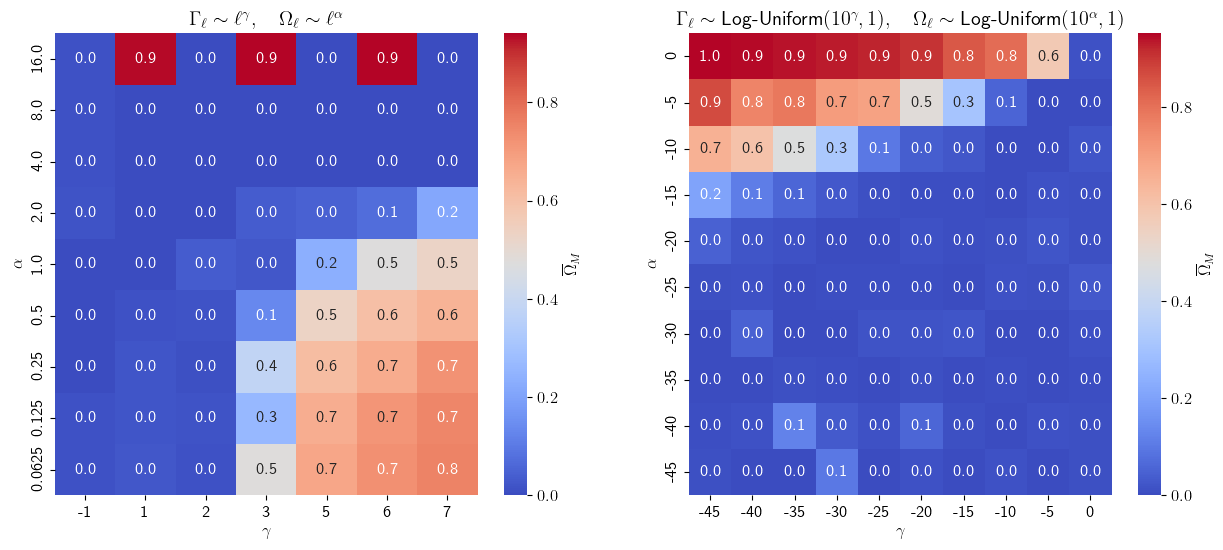

<Figure size 640x480 with 0 Axes>

In [9]:
heatmap_data_power_law = power_law_df.pivot_table(index='alpha', columns='gamma', values='abundance_val', aggfunc='mean')
heatmap_data_log_uniform = log_uniform_df.pivot_table(index='lower_omega', columns='lower_gamma', values='abundance_val', aggfunc='mean')

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'  # Add more packages if needed
plt.rcParams['font.size'] = 12

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(heatmap_data_power_law, annot=True, cmap='coolwarm', fmt=".1f", cbar_kws={'label': r'$\overline{\Omega}_M$'}, annot_kws={"ha": 'center', "va": 'center'}, ax=axs[0])
axs[0].set_title(r'$\Gamma_\ell \sim \ell^\gamma,\quad  \Omega_\ell \sim \ell^\alpha$')
axs[0].set_xlabel(r'$\gamma$')
axs[0].set_ylabel(r'$\alpha$')
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].invert_yaxis()

sns.heatmap(heatmap_data_log_uniform, annot=True, cmap='coolwarm', fmt=".1f", cbar_kws={'label': r'$\overline{\Omega}_M$'}, annot_kws={"ha": 'center', "va": 'center'}, ax=axs[1])
axs[1].set_title(r'$\Gamma_\ell \sim \text{Log-Uniform}(10^{\gamma}, 1),\quad  \Omega_\ell \sim \text{Log-Uniform}(10^{\alpha}, 1)$')
axs[1].set_xlabel(r'$\gamma$')
axs[1].set_ylabel(r'$\alpha$')
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].invert_yaxis()

plt.show()
plt.tight_layout();

There is a clear transition in both $e$-fold and abundance space towards allowed and disallowed parameters that yield stasis. Lets look at the maximum $e$-folds for both distributions and see how they look.

In [10]:
## isolate lower gamma = 7 and lower alpha = 1 omega and gamma from power_law_df
mre_omega_power_law = power_law_df[(power_law_df['gamma'] == 7) & (power_law_df['alpha'] == 0.0625)]['omegas'].values[0].squeeze()
mre_gamma_power_law = power_law_df[(power_law_df['gamma'] == 7) & (power_law_df['alpha'] == 0.0625)]['gammas'].values[0].squeeze()
mre_omega_log_uniform = log_uniform_df[(log_uniform_df['lower_gamma'] == -45) & (log_uniform_df['lower_omega'] == 0)]['omegas'].values[0].squeeze()
mre_gamma_log_uniform = log_uniform_df[(log_uniform_df['lower_gamma'] == -45) & (log_uniform_df['lower_omega'] == 0)]['gammas'].values[0].squeeze()

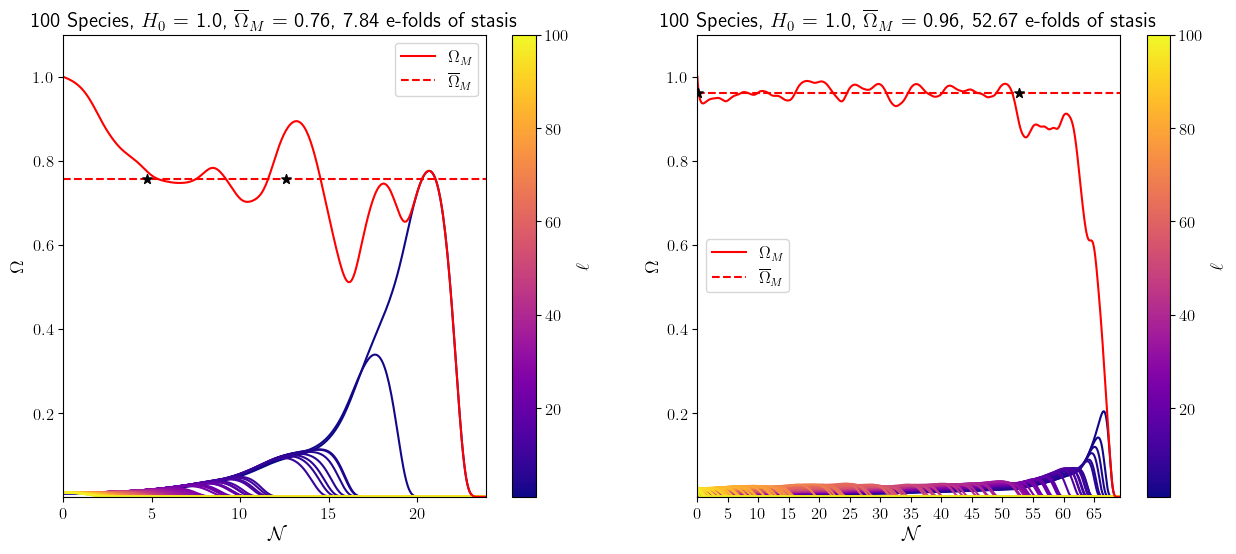

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sim = NonDiffStasisSolver(Omega_0=mre_omega_power_law, Gamma_0=mre_gamma_power_law, H_0 = 1.)
stasis_val, asymptote_val = sim.return_stasis()
sim.plot_abundance(ax=axs[0])

sim = NonDiffStasisSolver(Omega_0=mre_omega_log_uniform, Gamma_0=mre_gamma_log_uniform, H_0 = 1.)
stasis_val, asymptote_val = sim.return_stasis()
sim.plot_abundance(ax=axs[1])